## Extract text from notebooks
* Just markdown and source (maybe raw?)
* Use nbconvert to standardize version / extractions
* Keep cells in order
* TODO: which exceptions to catch?

In [2]:
import nbformat

NB_VERSION = 4

def extract_text(notebook_str):
    """ Extract code and markdown
    Args:
        * notebook_str - notebook as a string
    Returns:
        * str - select code and markdown source (and outputs)
    Pre:
        * notebook_str is well-formed per notebook version 4
        * 'cell_type' is defined for all cells
        * 'source' defined for all 'code' and 'markdown' cells
    Throws:
        * Anything nbformat.reads() can throw :( which is diverse and poorly
        documented, hence the `except Exception` in handler()
    Notes:
        * Deliberately decided not to index output streams and display strings
        because they were noisy and low value

    """
    formatted = nbformat.reads(notebook_str, as_version=NB_VERSION)
    text = []
    for cell in formatted.get('cells', []):
        if 'source' in cell and 'cell_type' in cell:
            if cell['cell_type'] == 'code' or cell['cell_type'] == 'markdown':
                text.append(cell['source'])

    return '\n'.join(text)

## Gather parseable notebooks in memory
If you have lots of notebooks or tiny amounts of RAM, use disk instead of RAM.

In [ ]:
from os.path import basename
import glob
import traceback

nbs = glob.glob("/Users/karve/Desktop/tmpnbs/*.ipynb")

good_nbs = []
for n in nbs:
    with open(n, 'r') as f:
        data = f.read()
        try:
            outstr = extract_text(data)
            good_nbs.append(n)
            fname = basename(n)
            with open(f"extracts/{fname}", "w+") as f:
                f.write(outstr)
        except Exception as e:
            print(f"skipping {n}")

## Build TF matrix, IDF vector

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(input='filename', preprocessor=extract_text)
X = vectorizer.fit_transform(good_nbs)

> The vectorizer's vocabulary contains all words it encountered, minus stop words

### Peek at what vectorizer learned

> Omit digit strings, since our ElasticSearch endpoint doesn't index them.

In [10]:
import re
vocab = {t:i for t,i in vectorizer.vocabulary_.items() if not re.fullmatch('\d+', t)}
len(vocab)

163959

> It's a long list, so let's just peek at the first few.

In [11]:
import itertools
{k:v for k,v in itertools.islice(vocab.items(), 0, 10)}

{'Capstone': 21871,
 'Project': 41371,
 'Introduction': 32328,
 'Part': 40148,
 'Having': 30608,
 'experimented': 80550,
 'with': 145227,
 'the': 136390,
 'NLTK': 37455,
 'library': 98219}

> `vocab` maps each term to an index in the `idf_` array

In [15]:
idf = vectorizer.idf_
idf[0:10]

array([4.38700625, 4.4723661 , 6.89026204, 7.47804871, 6.44842929,
       8.39433944, 9.08748662, 8.68202151, 9.08748662, 8.68202151])

### Map vocabulary to IDF

In [17]:
import pandas as pd

t2idf = {t:idf[i] for t,i in vocab.items()}
# put it in a pandas dataframe
t2idf_ = pd.DataFrame(list(t2idf.items()), columns=['term', 'idf'])

In [18]:
t2idf_.head()

,term,idf
0,Capstone,6.784902
1,Project,4.178515
2,Introduction,4.160233
3,Part,4.699229
4,Having,6.091754


In [19]:
asc_idf = t2idf_.sort_values('idf')

### Terms with low IDF
Are super common, present in almost all docs

In [21]:
asc_idf.head(50)

,term,idf
60,import,1.135223
62,as,1.175613
14,in,1.209142
98,for,1.230780
41,from,1.253688
119,print,1.425960
10,and,1.461892
7,the,1.465312
52,data,1.491848
58,of,1.500683


### Terms with high IDF
Are idiosynchractic; unique to a single doc

In [22]:
asc_idf.tail(10)

,term,idf
95255,desisim,9.087487
95254,ELG,9.087487
95253,DESI,9.087487
95252,Pika,9.087487
95251,subscribing,9.087487
95250,comp540,9.087487
95249,Vandermonde,9.087487
95247,MGS,9.087487
95256,Moustakas,9.087487
163958,r_2223,9.087487


### See how IDFs are distributed

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12a1c2b70>]],
      dtype=object)

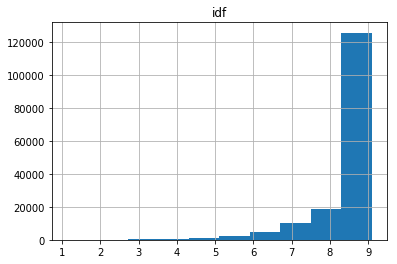

In [23]:
%matplotlib inline
asc_idf.hist(column='idf', bins=10)

### Grab 10 terms from each decile

In [24]:
import math
import numpy as np
import pickle

# flip the vocab so we can look up terms by index
i2t = {t:i for i,t in vocab.items()}
# sort by idf; only take terms in vocabulary
ascending_i = [i for i in np.argsort(idf) if i in i2t]

decile_size = math.floor(len(vocab) * .1)

decile_sample = {}
for d in range(0, 10):
    decile = ascending_i[decile_size * d: decile_size * (d+1)]
    random_i = np.random.choice(decile, 10, replace=False)
    decile_sample[d] = {i2t[j]:idf[j] for j in random_i}

with open("./dec_sample.pkl", 'wb') as f:
    pickle.dump(decile_sample, f)

In [25]:
decile_sample

{0: {'stats': 3.1098674786491096,
  'Energie': 6.484796933490655,
  'img_size': 6.522537261473502,
  'younger': 6.561757974626783,
  'programmers': 6.254273274878822,
  'regard': 6.836194820328544,
  'bundled': 7.072583598392774,
  'mc': 6.645139583565834,
  'paging': 6.947420455438768,
  'Не': 6.736111361771561},
 1: {'Jonathan': 7.8347236504396705,
  'Rotate': 7.701192257815148,
  'Postbank': 7.583409222158765,
  'p_true': 7.583409222158765,
  'func_globals': 7.988874330266929,
  'Station': 7.382738526696613,
  'sigmax': 7.701192257815148,
  'Early': 7.8347236504396705,
  'warehouse': 7.478048706500939,
  'interupted': 8.171195887060883},
 2: {'right_boundary': 8.394339438375093,
  'Problema': 8.394339438375093,
  '문구가': 8.171195887060883,
  'concert': 8.394339438375093,
  'gerar': 8.394339438375093,
  'Zebra': 8.171195887060883,
  'важен': 8.171195887060883,
  'magspec': 8.171195887060883,
  'img_cols': 8.171195887060883,
  'skullstrip': 8.394339438375093},
 3: {'start3': 8.68202151

> Neat. Good mix of languages (Russian, Chinese, English, German), numbers, variables, plain text.